In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D

from sklearn import metrics

In [2]:
df = pd.read_csv('BuyTitleOfferEval.csv', header=0, index_col=0)

C:\Users\WMiller\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 921907 entries, 0 to 921906
Data columns (total 18 columns):
LocationNo                             921907 non-null object
CatalogID                              921907 non-null int64
CatalogBinding                         921907 non-null object
count_ItemsPriced                      921907 non-null int64
count_ItemsSold                        921907 non-null int64
avg_CatalogAccDays_NR                  921907 non-null float64
avg_CatalogAccDays_TrashPenalty_R40    921907 non-null float64
avg_CatalogAccDays_TrashPenalty_R42    921907 non-null float64
actual_AvgSalePrice                    614557 non-null float64
actual_BuyGradeName_R40                921907 non-null object
actual_BuyOfferPct_R40                 921907 non-null float64
actual_BuyOfferAmt_R40                 614557 non-null float64
pred_AvgSalePrice                      409833 non-null float64
pred_BuyOfferPct_R40                   409833 non-null float64
pred_SuggestedOf

In [4]:
df['count_ItemsPriced'].sum()

1278018

In [4]:
filt_Chain = df['LocationNo'] == 'Chain'
filt_Loc = ~filt_Chain
df_Chain = df[filt_Chain].reset_index(drop=True)
df_Loc = df[filt_Loc].reset_index()

In [5]:
df_Chain['actual_TotalBuyOffers_R40'] = df_Chain['actual_BuyOfferAmt_R40'] * df_Chain['count_ItemsPriced']
df_Chain['pred_TotalSuggestedOffers_R40'] = df_Chain['pred_SuggestedOffer_R40'] * df_Chain['count_ItemsPriced']
df_Chain['error_AAD_R40'] = df_Chain['pred_AAD_R40'] - df_Chain['avg_CatalogAccDays_TrashPenalty_R40']
df_Chain['RSE_AAD_R40'] = np.sqrt((df_Chain['pred_AAD_R40'] - df_Chain['avg_CatalogAccDays_TrashPenalty_R40'])**2)

In [6]:
df_Chain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298416 entries, 0 to 298415
Data columns (total 22 columns):
LocationNo                             298416 non-null object
CatalogID                              298416 non-null int64
CatalogBinding                         298416 non-null object
count_ItemsPriced                      298416 non-null int64
count_ItemsSold                        298416 non-null int64
avg_CatalogAccDays_NR                  298416 non-null float64
avg_CatalogAccDays_TrashPenalty_R40    298416 non-null float64
avg_CatalogAccDays_TrashPenalty_R42    298416 non-null float64
actual_AvgSalePrice                    207855 non-null float64
actual_BuyGradeName_R40                298416 non-null object
actual_BuyOfferPct_R40                 298416 non-null float64
actual_BuyOfferAmt_R40                 207855 non-null float64
pred_AvgSalePrice                      298416 non-null float64
pred_BuyOfferPct_R40                   298416 non-null float64
pred_SuggestedOf

In [7]:
def create_PredCompDF(df, minSampleNum, binding='', **kwargs):
    list_Bindings = df['CatalogBinding'].unique()
    if (binding in list_Bindings) == False:
        binding = list_Bindings
    else: 
        binding = [binding]
    filt_QtyNPlus= (df['count_ItemsPriced'] >= minSampleNum) & (df['CatalogBinding'].isin(binding))
    df_PredCompUngrouped = df[filt_QtyNPlus].reset_index(drop=True)
    df_PredComp = df_PredCompUngrouped.groupby(['pred_BuyOfferPct_R40', 'actual_BuyOfferPct_R40']).sum()[['count_ItemsPriced', 'count_ItemsSold']].reset_index()
    return df_PredComp

def calc_CatAcc(df, gradeThreshold=0.3, **kwargs):
    filt_EqualGrades = df['pred_BuyOfferPct_R40'] == df['actual_BuyOfferPct_R40']
    filt_GradeThreshold = df['pred_BuyOfferPct_R40'] >= gradeThreshold
    df_AccByGrade = (df[filt_EqualGrades & filt_GradeThreshold]['count_ItemsPriced'].sum() /
                     df[filt_GradeThreshold]['count_ItemsPriced'].sum())
    return df_AccByGrade

def calc_CatAccByGrade(df):
    filt_EqualGrades = df['pred_BuyOfferPct_R40'] == df['actual_BuyOfferPct_R40']
    df_AccByGrade = pd.DataFrame((df[filt_EqualGrades].groupby('pred_BuyOfferPct_R40').sum()['count_ItemsPriced'] /
                     df.groupby('pred_BuyOfferPct_R40').sum()['count_ItemsPriced']))
    df_AccByGrade= df_AccByGrade.merge(df.groupby('pred_BuyOfferPct_R40').sum()['count_ItemsPriced'], on='pred_BuyOfferPct_R40').reset_index()
    df_AccByGrade.rename(columns={'pred_BuyOfferPct_R40': 'Suggested Offer Grade', 'count_ItemsPriced_x': 'Pct Accuracy', 'count_ItemsPriced_y': 'Total Qty'}, inplace=True)
    return df_AccByGrade

def calc_CatPredPctsByGrade(df, gradeThreshold=0, **kwargs):
    df_PredPctsByGrade = df.merge(df.groupby('pred_BuyOfferPct_R40').sum()['count_ItemsPriced'], on='pred_BuyOfferPct_R40')
    df_PredPctsByGrade['pct_ActualGrades'] = df_PredPctsByGrade['count_ItemsPriced_x'] / df_PredPctsByGrade['count_ItemsPriced_y']
    df_PredPctsByGrade.rename(columns={'pred_BuyOfferPct_R40': 'Suggested Offer Grade', 
                                       'actual_BuyOfferPct_R40': 'Actual Grade',
                                       'count_ItemsPriced_x': 'Qty Actual Grades',
                                       'pct_ActualGrades': 'Pct Actual Grades'}, inplace=True)
    filt_GradeThreshold = df_PredPctsByGrade['Suggested Offer Grade'] >= gradeThreshold
    return df_PredPctsByGrade[filt_GradeThreshold][['Suggested Offer Grade', 'Actual Grade', 'Qty Actual Grades', 'Pct Actual Grades']]

def calc_MRSE(pred, targ):
    mrse = np.sqrt(np.mean([((t - p)**2) for (p, t) in zip(pred, targ)]))
    return mrse

In [8]:
df_Chain.dropna(inplace=True)

In [9]:
calc_MRSE(df_Chain['avg_CatalogAccDays_NR'], df_Chain['pred_AAD_R40'])

75.53276891589047

In [10]:
calc_MRSE(df_Chain['avg_CatalogAccDays_TrashPenalty_R40'], df_Chain['pred_AAD_R40'])

77.28994040491332

In [11]:
calc_MRSE(df_Chain['avg_CatalogAccDays_TrashPenalty_R40'], df_Chain['pred_AAD_R42'])

406.48236503250934

In [12]:
filt_Grade = df_Chain['pred_BuyOfferPct_R40'] > 0
filt_QtyThreshold = df_Chain['count_ItemsPriced'] >= 5
filt_Binding = df_Chain['CatalogBinding'] == 'General'

In [13]:
calc_MRSE(df_Chain[filt_Binding & filt_QtyThreshold]['avg_CatalogAccDays_TrashPenalty_R40'], 
          df_Chain[filt_Binding & filt_QtyThreshold]['pred_AAD_R40'])

44.95867138436621

In [14]:
calc_MRSE(df_Chain[filt_Grade & filt_Binding & filt_QtyThreshold]['avg_CatalogAccDays_TrashPenalty_R40'], 
          df_Chain[filt_Grade & filt_Binding & filt_QtyThreshold]['pred_AAD_R40'])

44.410531753606946

In [15]:
df_ChainPredComp = create_PredCompDF(df_Chain[filt_Binding], 5)
print(calc_CatAcc(df_ChainPredComp, gradeThreshold=0))
calc_CatAccByGrade(df_ChainPredComp)

0.5714565247167633


,Suggested Offer Grade,Pct Accuracy,Total Qty
0,0.00,0.593522,3149
1,0.05,0.681875,41053
2,0.20,0.593953,76240
3,0.30,0.418118,28370
4,0.40,0.134739,4505


In [16]:
calc_CatPredPctsByGrade(df_ChainPredComp, gradeThreshold=0)

,Suggested Offer Grade,Actual Grade,Qty Actual Grades,Pct Actual Grades
0,0.00,0.00,1869,0.593522
1,0.00,0.05,1198,0.380438
2,0.00,0.20,74,0.023500
3,0.00,0.40,8,0.002540
4,0.05,0.00,7486,0.182350
5,0.05,0.05,27993,0.681875
6,0.05,0.20,5359,0.130539
7,0.05,0.30,198,0.004823
8,0.05,0.40,17,0.000414
9,0.20,0.00,1124,0.014743


In [17]:
filt_actual = df_Chain['actual_BuyOfferPct_R40'] == 0.4
filt_pred = df_Chain['pred_BuyOfferPct_R40'] == 0.4
filt_accurate = df_Chain['pred_BuyOfferPct_R40'] == df_Chain['actual_BuyOfferPct_R40']

df_Chain[filt_accurate & filt_pred]['count_ItemsPriced'].sum() / df_Chain[filt_pred]['count_ItemsPriced'].sum()

0.17386133904150314

In [18]:
df_LocPredComp = create_PredCompDF(df_Loc, 1)
print(calc_CatAcc(df_LocPredComp, gradeThreshold=0))
calc_CatAccByGrade(df_LocPredComp)

0.3043501578253808


,Suggested Offer Grade,Pct Accuracy,Total Qty
0,0.00,0.540429,7742
1,0.05,0.181554,21685
2,0.10,0.336812,6707
3,0.20,0.312228,52010
4,0.30,0.296867,35494
5,0.40,0.373076,6886


In [19]:
def create_ConfusionMatrix_Normalized(df):
    df_cm = (df.groupby(['pred_BuyOfferPct_R40', 'actual_BuyOfferPct_R40']).sum()['count_ItemsPriced']/
              df.groupby(['pred_BuyOfferPct_R40']).sum()['count_ItemsPriced'])
    df_cm = df_cm.unstack('actual_BuyOfferPct_R40').fillna(0).stack('actual_BuyOfferPct_R40').sort_index(ascending=False) #Add zeros where nulls result in no index value, sort the index
    idx_order = df_cm.index.levels[0].sort_values(ascending=False)
    array_cm = np.array([np.array(df_cm.loc[i]) for i in idx_order])
    return array_cm

def create_ConfusionMatrix(df):
    df_cm = (df.groupby(['pred_BuyOfferPct_R40', 'actual_BuyOfferPct_R40']).sum()['count_ItemsPriced']/
              df.sum()['count_ItemsPriced'])
    df_cm = df_cm.unstack('actual_BuyOfferPct_R40').fillna(0).stack('actual_BuyOfferPct_R40').sort_index(ascending=False)
    idx_order = df_cm.index.levels[0].sort_values(ascending=False)
    array_cm = ([list(df_cm.loc[i]) for i in idx_order])
    return array_cm

def plot_ConfusionMatrix(cm):
    fig, ax = plt.subplots(figsize=(8,6))
    #max_C = max([i for j in cm for i in j])
    sns.heatmap(cm, cmap = 'bone', vmin=0, vmax=max_C, annot=True, fmt='.1%', ax=ax)
    ax.set_xlabel('Actual Offer %', fontsize=14)
    ax.set_ylabel('Predicted Offer %', fontsize=14)
    ax.set_xticklabels([ '40%', '30%', '20%', '5%', '0%'])
    ax.set_yticklabels(['40%', '30%', '20%', '5%', '0%'])
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 0.2 * max_C, 0.4 * max_C, 0.6 * max_C, 0.8 * max_C, max_C])
    cbar.set_ticklabels(['{:0.0%}'.format(p) for p in [0, 0.2 * max_C, 0.4 * max_C, 0.6 * max_C, 0.8 * max_C, max_C]])
    #plt.savefig('./R40_ConfMatrix.png')
    plt.show()
    return

In [20]:
filt_QtyThreshold = df_Chain['count_ItemsPriced'] >= 3
filt_Binding = df_Chain['CatalogBinding'] == 'General'

In [21]:
df_ChainPredComp = create_PredCompDF(df_Chain[filt_Binding], 3)
print(calc_CatAcc(df_ChainPredComp, gradeThreshold=0))
calc_CatAccByGrade(df_ChainPredComp)

0.5447259027142559


,Suggested Offer Grade,Pct Accuracy,Total Qty
0,0.00,0.525313,9185
1,0.05,0.619254,67788
2,0.20,0.559806,102975
3,0.30,0.421384,35559
4,0.40,0.161629,5327


In [33]:
filt_LocNAPreds = df_Loc['pred_SuggestedOffer_R40'].isna()
df_Loc[~filt_LocNAPreds]

,index,LocationNo,CatalogID,CatalogBinding,count_ItemsPriced,count_ItemsSold,avg_CatalogAccDays_NR,avg_CatalogAccDays_TrashPenalty_R40,avg_CatalogAccDays_TrashPenalty_R42,actual_AvgSalePrice,actual_BuyGradeName_R40,actual_BuyOfferPct_R40,actual_BuyOfferAmt_R40,pred_AvgSalePrice,pred_BuyOfferPct_R40,pred_SuggestedOffer_R40,pred_AAD_R40,pred_AAD_R42,Date_Generated
0,0,1,19595,General,1,1,49.430000,49.430000,24.715000,7.9900,C,0.20,1.59800,3.0000,0.05,0.15,92.375000,115.468750,2019-04-01
5,5,1,102828,General,1,1,35.100000,35.100000,17.550000,6.9900,C,0.20,1.39800,5.1055,0.05,0.26,105.807778,211.615556,2019-04-01
6,6,1,111567,General,1,1,11.480000,11.480000,5.740000,7.9900,B,0.30,2.39700,3.4992,0.20,0.70,57.451096,77.665370,2019-04-01
12,12,1,201620,General,2,2,52.180000,52.180000,34.786667,4.4950,C,0.20,0.89900,4.2525,0.05,0.21,102.414894,137.528571,2019-04-01
16,16,1,267502,General,1,1,93.180000,93.180000,46.590000,1.9900,D,0.05,0.09950,1.9900,0.00,0.00,190.690000,381.380000,2019-04-01
18,18,1,285283,General,1,1,56.940000,56.940000,28.470000,2.4900,C,0.20,0.49800,2.3410,0.20,0.47,48.680000,68.152000,2019-04-01
21,21,1,411613,General,1,0,236.310000,236.310000,236.310000,NaN,E,0.00,NaN,3.7814,0.00,0.00,227.592000,NaN,2019-04-01
24,24,1,527115,General,1,1,15.700000,15.700000,7.850000,9.9900,B,0.30,2.99700,9.9900,0.20,2.00,40.817778,52.480000,2019-04-01
25,25,1,546108,General,1,1,92.250000,92.250000,46.125000,1.0000,D,0.05,0.05000,1.9900,0.30,0.60,20.546000,20.546000,2019-04-01
29,29,1,645099,General,1,1,41.250000,41.250000,20.625000,3.0000,C,0.20,0.60000,5.0613,0.20,1.01,59.360000,82.791579,2019-04-01


In [45]:
filt_LocQtyThreshold = df_Loc['count_ItemsPriced'] >= 2
filt_LocBinding = df_Loc['CatalogBinding'] == 'General'

In [46]:
df_Loc[~filt_LocNAPreds &filt_LocBinding & filt_LocQtyThreshold].describe()

,index,CatalogID,count_ItemsPriced,count_ItemsSold,avg_CatalogAccDays_NR,avg_CatalogAccDays_TrashPenalty_R40,avg_CatalogAccDays_TrashPenalty_R42,actual_AvgSalePrice,actual_BuyOfferPct_R40,actual_BuyOfferAmt_R40,pred_AvgSalePrice,pred_BuyOfferPct_R40,pred_SuggestedOffer_R40,pred_AAD_R40,pred_AAD_R42
count,11019.000000,1.101900e+04,11019.000000,11019.000000,11019.000000,11019.000000,11019.000000,10047.000000,11019.000000,10047.000000,11019.000000,11019.000000,11019.000000,11019.000000,10948.000000
mean,368617.582267,6.210284e+06,2.339051,1.846266,53.378591,73.696744,86.727763,6.069648,0.196592,1.315654,6.373982,0.226885,1.534214,51.398444,101.372278
std,261433.051504,3.655524e+06,1.446678,1.322192,50.617463,71.929530,142.143740,3.389189,0.127305,1.182200,3.550481,0.100569,1.319598,48.899823,214.759737
min,12.000000,4.575000e+03,2.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.750000,0.000000,0.000000,0.003333,0.370588
25%,122668.000000,3.939282e+06,2.000000,1.000000,16.882500,19.455000,13.981667,3.490000,0.050000,0.399500,4.071100,0.200000,0.680000,17.558756,20.565652
50%,421025.000000,5.361549e+06,2.000000,2.000000,36.486667,46.415000,33.043333,5.660000,0.200000,1.098000,5.992000,0.200000,1.290000,36.651579,46.163000
75%,583170.000000,8.804601e+06,2.000000,2.000000,74.415833,111.640000,98.730000,7.990000,0.300000,1.799000,7.790000,0.300000,2.070000,69.060045,101.490341
max,912149.000000,1.541090e+07,87.000000,65.000000,272.305000,408.900000,4003.760000,70.000000,0.400000,28.000000,107.144000,0.400000,34.420000,597.298000,7286.730000


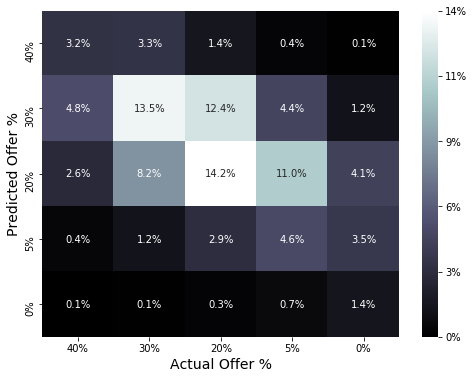

In [48]:
cm = create_ConfusionMatrix(df_Loc[~filt_LocNAPreds &filt_LocBinding & filt_LocQtyThreshold])
plot_ConfusionMatrix(cm)

In [30]:
df_Loc['pred_SuggestedOffer_R40'].dropna(axis=0)

0         0.15
5         0.26
6         0.70
12        0.21
16        0.00
18        0.47
21        0.00
24        2.00
25        0.60
29        1.01
30        0.08
44        2.10
46        0.00
47        1.33
52        1.99
53        0.26
56        3.68
58        0.00
60        0.25
66        0.26
68        0.22
70        0.08
72        0.10
77        1.52
82        1.45
88        0.53
99        1.50
102       0.97
106       0.17
113       1.40
          ... 
623195    1.00
623197    0.15
623211    1.66
623236    2.27
623238    0.20
623242    0.75
623244    1.18
623251    0.37
623252    0.75
623253    0.90
623262    0.50
623265    0.25
623275    0.17
623276    0.20
623283    0.00
623284    2.15
623289    1.21
623290    0.29
623303    0.37
623306    1.31
623313    0.30
623320    0.40
623330    0.12
623338    0.89
623386    0.00
623402    0.10
623407    0.20
623413    0.96
623432    0.20
623456    0.00
Name: pred_SuggestedOffer_R40, Length: 111417, dtype: float64

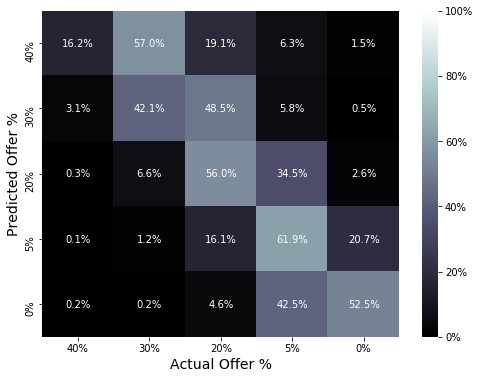

In [24]:
fig, ax = plt.subplots(figsize=(8,6))
C = create_ConfusionMatrix_Normalized(df_Chain[filt_Binding & filt_QtyThreshold])
# C = metrics.confusion_matrix(df_Chain[filt_Binding & filt_QtyThreshold]['actual_BuyOfferPct_R40'].astype(str), 
#                              df_Chain[filt_Binding & filt_QtyThreshold]['pred_BuyOfferPct_R40'].astype(str), 
#                                      labels=['0.4', '0.3', '0.2', '0.05', '0.0'])
sns.heatmap(C, cmap = 'bone', vmin=0, vmax=1, annot=True, fmt='.1%', ax=ax)
ax.set_xlabel('Actual Offer %', fontsize=14)
ax.set_ylabel('Predicted Offer %', fontsize=14)
ax.set_xticklabels([ '40%', '30%', '20%', '5%', '0%'])
ax.set_yticklabels(['40%', '30%', '20%', '5%', '0%'])
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
#plt.savefig('./R40_NormConfMatrix.png')
plt.show()

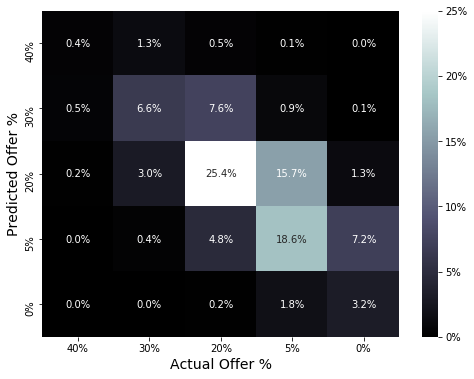

In [218]:
fig, ax = plt.subplots(figsize=(8,6))
C = create_ConfusionMatrix(df_Chain[filt_Binding & filt_QtyThreshold])
# C = metrics.confusion_matrix(df_Chain[filt_Binding & filt_QtyThreshold]['actual_BuyOfferPct_R40'].astype(str), 
#                              df_Chain[filt_Binding & filt_QtyThreshold]['pred_BuyOfferPct_R40'].astype(str), 
#                                      labels=['0.4', '0.3', '0.2', '0.05', '0.0'])
max_C = max([i for j in C for i in j])
sns.heatmap(C, cmap = 'bone', vmin=0, vmax=max_C, annot=True, fmt='.1%', ax=ax)
ax.set_xlabel('Actual Offer %', fontsize=14)
ax.set_ylabel('Predicted Offer %', fontsize=14)
ax.set_xticklabels([ '40%', '30%', '20%', '5%', '0%'])
ax.set_yticklabels(['40%', '30%', '20%', '5%', '0%'])
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.2 * max_C, 0.4 * max_C, 0.6 * max_C, 0.8 * max_C, max_C])
cbar.set_ticklabels(['{:0.0%}'.format(p) for p in [0, 0.2 * max_C, 0.4 * max_C, 0.6 * max_C, 0.8 * max_C, max_C]])
#plt.savefig('./R40_ConfMatrix.png')
plt.show()


In [219]:
print((df_Chain[filt_Binding & filt_QtyThreshold]['actual_BuyOfferAmt_R40'] * 
       df_Chain[filt_Binding & filt_QtyThreshold]['count_ItemsPriced']).sum())

print((df_Chain[filt_Binding & filt_QtyThreshold]['pred_SuggestedOffer_R40'] * 
       df_Chain[filt_Binding & filt_QtyThreshold]['count_ItemsPriced']).sum())

print((df_Chain[filt_Binding & filt_QtyThreshold]['actual_BuyOfferAmt_R40'] * 
       df_Chain[filt_Binding & filt_QtyThreshold]['count_ItemsPriced']).sum() -
     (df_Chain[filt_Binding & filt_QtyThreshold]['pred_SuggestedOffer_R40'] * 
       df_Chain[filt_Binding & filt_QtyThreshold]['count_ItemsPriced']).sum())

print((df_Chain[filt_Binding & filt_QtyThreshold]['pred_SuggestedOffer_R40'] * 
       df_Chain[filt_Binding & filt_QtyThreshold]['count_ItemsPriced']).sum()/
     (df_Chain[filt_Binding & filt_QtyThreshold]['actual_BuyOfferAmt_R40'] * 
      df_Chain[filt_Binding & filt_QtyThreshold]['count_ItemsPriced']).sum())

209851.37710500002
266721.77999999997
-56870.40289499995
1.2710032389568005


In [221]:
df_Chain['actual_TotalBuyOffers_R40'] = df_Chain['actual_BuyOfferAmt_R40'] * df_Chain['count_ItemsPriced']
df_Chain['pred_TotalSuggestedOffers_R40'] = df_Chain['pred_SuggestedOffer_R40'] * df_Chain['count_ItemsPriced']
df_Chain['error_AAD_R40'] = df_Chain['pred_AAD_R40'] - df_Chain['avg_CatalogAccDays_TrashPenalty_R40']
df_Chain['RSE_AAD_R40'] = np.sqrt((df_Chain['pred_AAD_R40'] - df_Chain['avg_CatalogAccDays_TrashPenalty_R40'])**2)

In [222]:
df_Chain[filt_Binding].groupby('pred_BuyOfferPct_R40')['actual_TotalBuyOffers_R40', 'pred_TotalSuggestedOffers_R40'].sum()

,actual_TotalBuyOffers_R40,pred_TotalSuggestedOffers_R40
pred_BuyOfferPct_R40,,
0.00,19155.170700,0.00
0.05,78586.466475,44967.92
0.20,190426.299540,245673.82
0.30,116445.703885,158853.76
0.40,22835.116005,44529.25


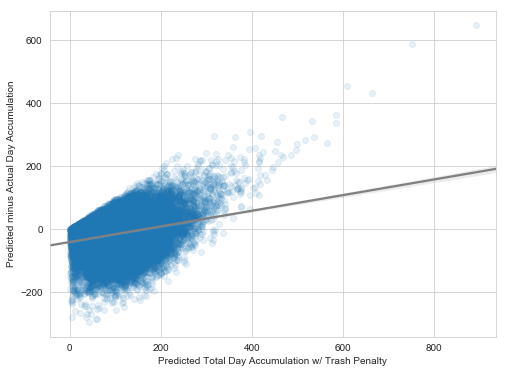

In [223]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,6))
sns.regplot(df_Chain[filt_Binding & filt_QtyThreshold]['pred_AAD_R40'],
            df_Chain[filt_Binding & filt_QtyThreshold]['error_AAD_R40'],
            scatter_kws=dict(alpha=0.1),
            line_kws=dict(color='grey'))
ax.set_xlabel('Predicted Total Day Accumulation w/ Trash Penalty')
ax.set_ylabel('Predicted minus Actual Day Accumulation')
#plt.savefig('./R40_ContinuousErrorRegPlot.png')
plt.show()

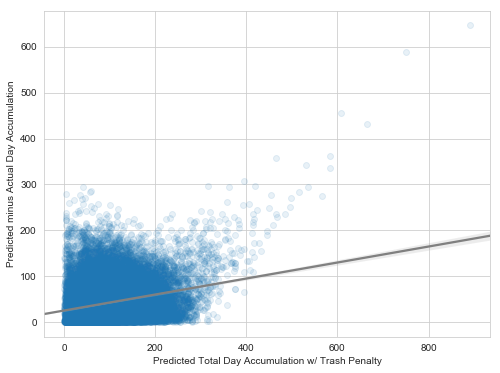

In [224]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,6))
sns.regplot(df_Chain[filt_Binding & filt_QtyThreshold]['pred_AAD_R40'],
            df_Chain[filt_Binding & filt_QtyThreshold]['RSE_AAD_R40'],
            scatter_kws=dict(alpha=0.1),
            line_kws=dict(color='grey'))
ax.set_xlabel('Predicted Total Day Accumulation w/ Trash Penalty')
ax.set_ylabel('Predicted minus Actual Day Accumulation')
#plt.savefig('./R40_ContinuousRSERegPlot.png')
plt.show()

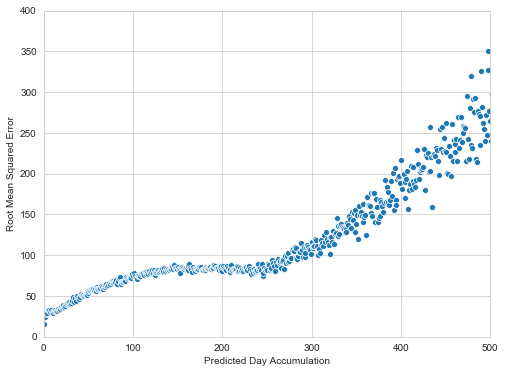

In [226]:
df_plt = df_Chain[filt_Binding][['pred_AAD_R40', 'RSE_AAD_R40']]
df_plt['pred_AAD_R40'] = round(df_plt['pred_AAD_R40'], 0)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(df_plt.groupby('pred_AAD_R40')['pred_AAD_R40'].mean(),
                df_plt.groupby('pred_AAD_R40')['RSE_AAD_R40'].mean(),
                ax = ax)
ax.set_xlim([0, 500])
ax.set_ylim([0, 400])
ax.set_xlabel('Predicted Day Accumulation')
ax.set_ylabel('Root Mean Squared Error')
#plt.savefig('./R40_ContinuousRMSE_500Scale.png')
plt.show()

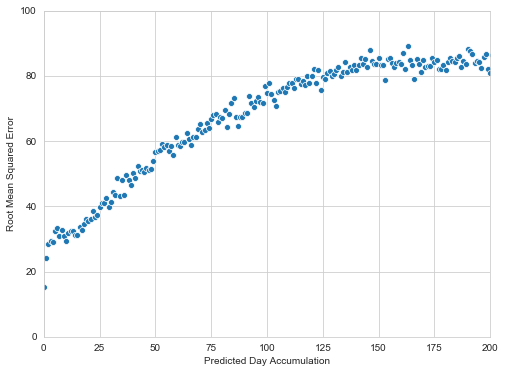

In [227]:
df_plt = df_Chain[filt_Binding][['pred_AAD_R40', 'RSE_AAD_R40']]
df_plt['pred_AAD_R40'] = round(df_plt['pred_AAD_R40'], 0)
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(df_plt.groupby('pred_AAD_R40')['pred_AAD_R40'].mean(),
                df_plt.groupby('pred_AAD_R40')['RSE_AAD_R40'].mean(),
                ax = ax)
ax.set_xlim([0, 200])
ax.set_ylim([0, 100])
ax.set_xlabel('Predicted Day Accumulation')
ax.set_ylabel('Root Mean Squared Error')
#plt.savefig('./R40_ContinuousRMSE_200Scale.png')
plt.show()

In [228]:
df_Chain.groupby('pred_BuyOfferPct_R40')['RSE_AAD_R40'].mean()

pred_BuyOfferPct_R40
0.00    96.315935
0.05    79.255363
0.10    57.035199
0.20    58.720557
0.30    38.381644
0.40    36.955611
Name: RSE_AAD_R40, dtype: float64

In [229]:
df_Chain.groupby('pred_BuyOfferPct_R40')['RSE_AAD_R40'].median()

pred_BuyOfferPct_R40
0.00    77.153810
0.05    72.398378
0.10    39.400607
0.20    39.515637
0.30    17.620526
0.40     7.482876
Name: RSE_AAD_R40, dtype: float64

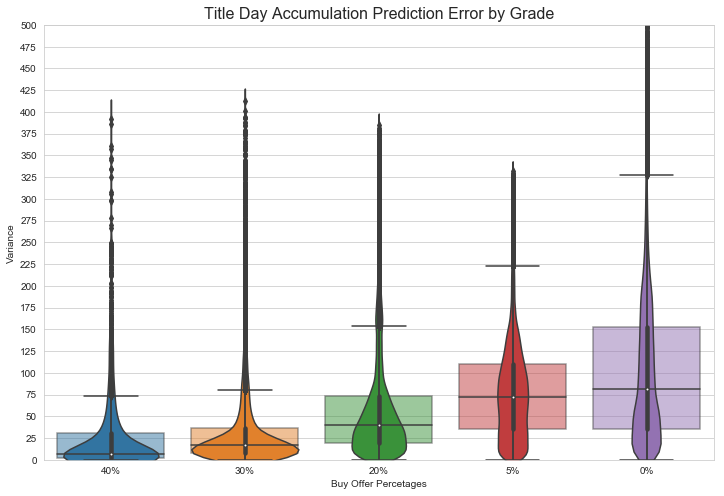

In [233]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x='pred_BuyOfferPct_R40', y='RSE_AAD_R40', order=[0.4, 0.3, 0.2, 0.05, 0.0], data=df_Chain[filt_Binding], ax=ax, boxprops=dict(alpha=.5))
sns.violinplot(x='pred_BuyOfferPct_R40', y='RSE_AAD_R40', order=[0.4, 0.3, 0.2, 0.05, 0.0], data=df_Chain[filt_Binding], ax=ax)
ax.set_ylim(0,500)
ax.set_xlabel('Buy Offer Percetages')
ax.set_xticklabels([ '40%', '30%', '20%', '5%', '0%'])
ax.set_ylabel('Variance')
ax.yaxis.set_major_locator(mtick.MultipleLocator(25))
#plt.savefig('./R40_ErrorsByGrade_VioBox.png')
ax.set_title('Title Day Accumulation Prediction Error by Grade', fontsize=16)
plt.show()

In [ ]:
df_Chain.info()

In [ ]:

(df_Chain.groupby(['pred_BuyOfferPct_R40', 'actual_BuyOfferPct_R40']).sum()['count_ItemsPriced']/
 df_Chain.groupby(['pred_BuyOfferPct_R40']).sum()['count_ItemsPriced']).sort_values(ascending=False)

In [ ]:
df_Chain.info()